# Olympic Track Times Analysis
### James Martin - Georgia Tech CSE 6040

Being a former track and field athlete, I wanted to analyze some data about it. I found a pretty thorough list of Olympic Medal winner's times from the 20th and 21st centuries. As time goes on, we expect times to continue to get faster as shoe performance and training improves. Looking at some of the track data, I wanted to perform linear regression to get a prediction and compare it to Tokyo's results. I expect the error to be less in sprint races than distance, as distance races can be more tactical and times are more likely to vary.

Also with the Olympics, a lot of the distance events for women weren't held until a lot more recently, so the data will be relatively new. (To keep it consistent, I kept the years the same between men and women even though there was more men's data). With that being said, I think the sprint events will also be predicted slower than actual since some of the data is from the early 20th century, where results were much slower.

## Data Preparation

Data taken from https://www.kaggle.com/jayrav13/olympic-track-field-results/version/1

In [2]:
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt
from numpy import mean
from statistics import stdev
from scipy.stats import ttest_rel
plt.style.use('seaborn-poster')

In [3]:
tf = pd.read_csv(r'C:/Users/jimmy/OneDrive/Desktop/CSE 6040/tfresults.csv')

In [4]:
tf.head(5)

,Gender,Event,Location,Year,Medal,Name,Nationality,Result
0,M,10000M Men,Rio,2016,G,Mohamed FARAH,GBR,27:05.0
1,M,10000M Men,Rio,2016,S,Paul Kipngetich TANUI,KEN,27:05.6
2,M,10000M Men,Rio,2016,B,Tamirat TOLA,ETH,27:06.3
3,M,10000M Men,Beijing,2008,G,Kenenisa BEKELE,ETH,27:01.2
4,M,10000M Men,Beijing,2008,S,Sileshi SIHINE,ETH,27:02.8


In [5]:
tf.shape

(2394, 8)

In [6]:
tf = tf.dropna() #Some rows had missing times and relays were dropped as the name column was blank
tf.shape

(2135, 8)

In [7]:
tf.head()

,Gender,Event,Location,Year,Medal,Name,Nationality,Result
0,M,10000M Men,Rio,2016,G,Mohamed FARAH,GBR,27:05.0
1,M,10000M Men,Rio,2016,S,Paul Kipngetich TANUI,KEN,27:05.6
2,M,10000M Men,Rio,2016,B,Tamirat TOLA,ETH,27:06.3
3,M,10000M Men,Beijing,2008,G,Kenenisa BEKELE,ETH,27:01.2
4,M,10000M Men,Beijing,2008,S,Sileshi SIHINE,ETH,27:02.8


In [8]:
Unique_Events = tf.Event.unique()

## Converting Results
Want to remove the gender from the Event category since there's already a standalone Gender category
Need to split the results into seconds to make analyzing the data conistent and easy. There are many different forms of times from the database.

In [9]:
import time
import datetime
tf['Event'] = tf['Event'].str.replace('\sMen|\sWomen', '')
def distance_map(row):
    try:
        return int(row)
    except ValueError:
        return np.nan
    
tf['Distance (m)'] = tf['Event'].str.replace("M$", "").apply(lambda row: 42195.0 if row == "Marathon" else distance_map(row))
def time_map(row):
    x = datetime.time()
    if np.isnan(row['Distance (m)']):
        return np.nan
    else:
        try:
            x = datetime.datetime.strptime(row['Result'], "%H:%M:%S")
            return datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second).total_seconds()
        except ValueError:
            pass
        try:
            x = datetime.datetime.strptime(row['Result'], "%H:%M:%S.%f")
            return datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second, microseconds = x.microsecond).total_seconds()
        except ValueError:
            pass
        try:
            x = datetime.datetime.strptime(row['Result'], "%Hh%M:%S")
            return datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second).total_seconds()
        except ValueError:
            pass
        try:
            x = datetime.datetime.strptime(row['Result'], "%H-%M:%S")
            return datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second).total_seconds()
        except ValueError:
            pass
        try:
            x = datetime.datetime.strptime(row['Result'], "%H-%M:%S.%f")
            return datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second, microseconds = x.microsecond).total_seconds()
        except ValueError:
            pass
        try:
            x = datetime.datetime.strptime(row['Result'], "%M:%S.%f")
            return datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second, microseconds = x.microsecond).total_seconds()
        except ValueError:
            pass
        try:
            x = datetime.datetime.strptime(row['Result'], "%S.%f")
            return datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second, microseconds = x.microsecond).total_seconds()
        except ValueError:
            pass  
    
tf['Seconds'] = tf.apply(lambda row: time_map(row), axis=1)

<ipython-input-9-f972ad815098>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  tf['Event'] = tf['Event'].str.replace('\sMen|\sWomen', '')
<ipython-input-9-f972ad815098>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  tf['Distance (m)'] = tf['Event'].str.replace("M$", "").apply(lambda row: 42195.0 if row == "Marathon" else distance_map(row))


In [10]:
tf = tf.dropna() #remove all field events
tf.head()

,Gender,Event,Location,Year,Medal,Name,Nationality,Result,Distance (m),Seconds
0,M,10000M,Rio,2016,G,Mohamed FARAH,GBR,27:05.0,10000.0,1625.0
1,M,10000M,Rio,2016,S,Paul Kipngetich TANUI,KEN,27:05.6,10000.0,1625.6
2,M,10000M,Rio,2016,B,Tamirat TOLA,ETH,27:06.3,10000.0,1626.3
3,M,10000M,Beijing,2008,G,Kenenisa BEKELE,ETH,27:01.2,10000.0,1621.2
4,M,10000M,Beijing,2008,S,Sileshi SIHINE,ETH,27:02.8,10000.0,1622.8


### I split each of the following events (100,200,400,800,1500,5000,10000) into two chunks of code.
### The first displays the linear regression graph with the slope of the line and R-squared value.
### The second includes the Tokyo 2020 data, the prediction, the actual, and the error

## 100M Analysis

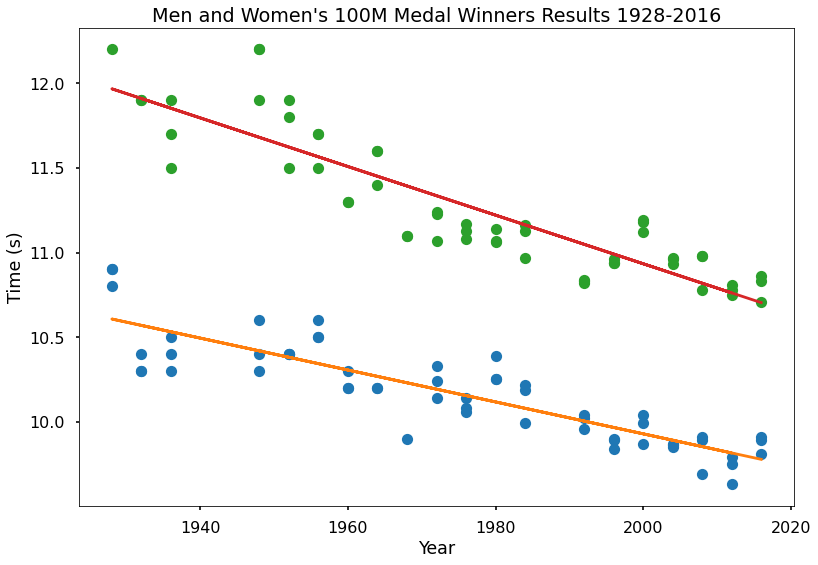

The equation of the men's line is y = 28.77542985758498 + -0.009β
The men's R2 value is -0.7716355654924806
The equation of the women's line is y = 39.648430585487034 + -0.014β
The women's R2 value is -0.789338838685434


In [11]:
one = tf.loc[tf['Event'] == '100M']
one = one.loc[tf['Year'] >= 1928] #Only have women's data from '28 on
one_m = one.loc[tf['Gender'] == 'M']
one_w = one.loc[tf['Gender'] == 'W']
x_m = one_m['Year'].values
y_m = one_m['Seconds'].values
x_w = one_w['Year'].values
y_w = one_w['Seconds'].values

plt.plot(x_m, y_m, 'o')
m, b = np.polyfit(x_m, y_m, 1)
plt.plot(x_m, m*x_m + b)
plt.plot(x_w, y_w, 'o')
m, b = np.polyfit(x_w, y_w, 1)
plt.plot(x_w, m*x_w + b)
plt.xlabel('Year')
plt.ylabel("Time (s)")
plt.title("Men and Women's 100M Medal Winners Results 1928-2016")
plt.show()

N_m = len(x_m)
x_mean_m = x_m.mean()
y_mean_m = y_m.mean()    
def linear_regression(x_m, y_m):     
    N_m = len(x_m)
    x_mean_m = x_m.mean()
    y_mean_m = y_m.mean()
    
    B1_num = ((x_m - x_mean_m) * (y_m - y_mean_m)).sum()
    B1_den = ((x_m - x_mean_m)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean_m - (B1*x_mean_m)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (reg_line)
print("The equation of the men's line is", linear_regression(x_m, y_m))
N_m = len(x_m)   
num = (N_m * (x_m*y_m).sum()) - (x_m.sum() * y_m.sum())
den = np.sqrt((N_m * (x_m**2).sum() - x_m.sum()**2) * (N_m * (y_m**2).sum() - y_m.sum()**2))
R2 = -(num / den) * (num/den)
print("The men's R2 value is", R2)

N_w = len(x_w)
x_mean_w = x_w.mean()
y_mean_w = y_w.mean()    
def linear_regression(x_w, y_w):     
    N_w = len(x_w)
    x_mean_w = x_w.mean()
    y_mean_w = y_w.mean()
    
    B1_num = ((x_w - x_mean_w) * (y_w - y_mean_w)).sum()
    B1_den = ((x_w - x_mean_w)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean_w - (B1*x_mean_w)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (reg_line)
print("The equation of the women's line is", linear_regression(x_w, y_w))
N_w = len(x_w)   
num = (N_w * (x_w*y_w).sum()) - (x_w.sum() * y_w.sum())
den = np.sqrt((N_w * (x_w**2).sum() - x_w.sum()**2) * (N_w * (y_w**2).sum() - y_w.sum()**2))
R2 = -(num / den) * (num/den)
print("The women's R2 value is", R2)

In [12]:
d_1m = {'Gender':['M', 'M', 'M'], 'Event': ['100M Men', '100M Men', '100M Men'], 'Location': ['Tokyo', 'Tokyo', 'Tokyo'], 
     'Year': ['2020', '2020', '2020'], 'Medal':['G', 'S', 'B'], 'Name':['Lamont Jacobs', 'Fred Kerley', 'Andre De Grasse'], 
     'Nationality':['ITA', 'USA', 'CAN'], 'Result':['9.80', '9.84', '9.89']}
d_1w = {'Gender':['W', 'W', 'W'], 'Event': ['100M Women', '100M Women', '100M Women'], 'Location': ['Tokyo', 'Tokyo', 'Tokyo'], 
     'Year': ['2020', '2020', '2020'], 'Medal':['G', 'S', 'B'], 'Name':['Elaine Thompson-Herah', 'Shelly-Ann Fraser-Pryce', 
     'Shericka Jackson'], 'Nationality':['JAM', 'JAM', 'JAM'], 'Result':['10.61', '10.74', '10.76']}
df_1m = pd.DataFrame(data=d_1m)
df_1m['Year'] = df_1m.Year.apply(lambda x: int(x))
df_1m['Result'] = df_1m.Result.apply(lambda x: float(x))
onem_prediction = (28.77542985758498) + (-0.009*2020)
print("Using a linear regression, the average prediction of the 2020 medal times was", onem_prediction, "seconds")
onem_avg = sum(df_1m['Result'].values) / 3
print("The average of the actual times were", onem_avg, "seconds")
onem_error =  (onem_avg - onem_prediction) / onem_avg * 100
print("The error was", onem_error,"%")
df_1w = pd.DataFrame(data=d_1w)
df_1w['Year'] = df_1w.Year.apply(lambda x: int(x))
df_1w['Result'] = df_1w.Result.apply(lambda x: float(x))
one_prediction_w = (39.648430585487034) + (-0.014*2020)
print("Using a linear regression, the average prediction of the 2020 medal times was", one_prediction_w, "seconds")
one_avg_w = sum(df_1w['Result'].values) / 3
print("The average of the actual times were", one_avg_w, "seconds")
one_error_w =  (one_avg_w - one_prediction_w) / one_avg_w * 100
print("The error was", one_error_w,"%")

Using a linear regression, the average prediction of the 2020 medal times was 10.595429857584982 seconds
The average of the actual times were 9.843333333333334 seconds
The error was -7.6406690577546374 %
Using a linear regression, the average prediction of the 2020 medal times was 11.368430585487033 seconds
The average of the actual times were 10.703333333333333 seconds
The error was -6.213926367054189 %


## 200M Analysis

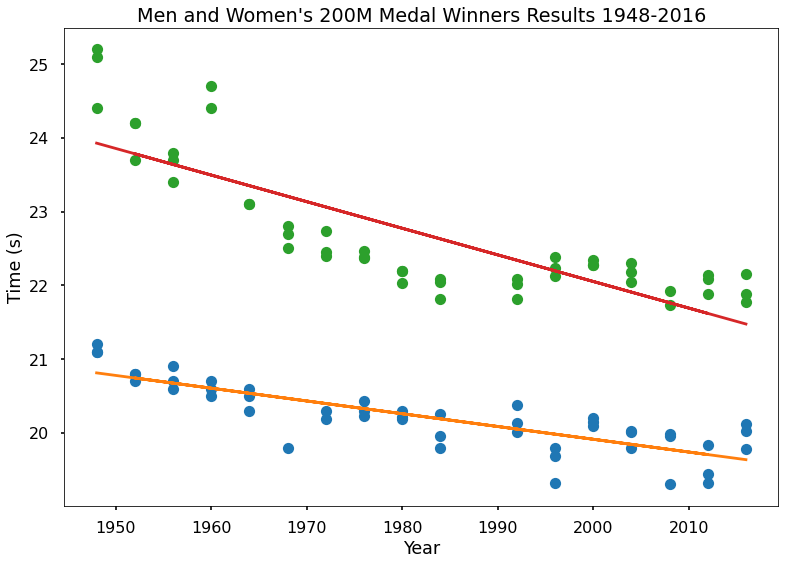

The equation of the men's line is y = 54.54242467951077 + -0.017β
The men's R2 value is -0.6901748970007375
The equation of the women's line is y = 94.22332984567093 + -0.036β
The women's R2 value is -0.6775034465421597


In [13]:
two = tf.loc[tf['Event'] == '200M']
two = two.loc[tf['Year'] >= 1948] #Only have women's data from '48 on
two_m = two.loc[tf['Gender'] == 'M']
two_w = two.loc[tf['Gender'] == 'W']
x_m = two_m['Year'].values
y_m = two_m['Seconds'].values
x_w = two_w['Year'].values
y_w = two_w['Seconds'].values

plt.plot(x_m, y_m, 'o')
m, b = np.polyfit(x_m, y_m, 1)
plt.plot(x_m, m*x_m + b)
plt.plot(x_w, y_w, 'o')
m, b = np.polyfit(x_w, y_w, 1)
plt.plot(x_w, m*x_w + b)
plt.xlabel('Year')
plt.ylabel("Time (s)")
plt.title("Men and Women's 200M Medal Winners Results 1948-2016")
plt.show()

N_m = len(x_m)
x_mean_m = x_m.mean()
y_mean_m = y_m.mean()    
def linear_regression(x_m, y_m):     
    N_m = len(x_m)
    x_mean_m = x_m.mean()
    y_mean_m = y_m.mean()
    
    B1_num = ((x_m - x_mean_m) * (y_m - y_mean_m)).sum()
    B1_den = ((x_m - x_mean_m)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean_m - (B1*x_mean_m)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (reg_line)
print("The equation of the men's line is", linear_regression(x_m, y_m))
N_m = len(x_m)   
num = (N_m * (x_m*y_m).sum()) - (x_m.sum() * y_m.sum())
den = np.sqrt((N_m * (x_m**2).sum() - x_m.sum()**2) * (N_m * (y_m**2).sum() - y_m.sum()**2))
R2 = -(num / den) * (num/den)
print("The men's R2 value is", R2)

N_w = len(x_w)
x_mean_w = x_w.mean()
y_mean_w = y_w.mean()    
def linear_regression(x_w, y_w):     
    N_w = len(x_w)
    x_mean_w = x_w.mean()
    y_mean_w = y_w.mean()
    
    B1_num = ((x_w - x_mean_w) * (y_w - y_mean_w)).sum()
    B1_den = ((x_w - x_mean_w)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean_w - (B1*x_mean_w)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (reg_line)
print("The equation of the women's line is", linear_regression(x_w, y_w))
N_w = len(x_w)   
num = (N_w * (x_w*y_w).sum()) - (x_w.sum() * y_w.sum())
den = np.sqrt((N_w * (x_w**2).sum() - x_w.sum()**2) * (N_w * (y_w**2).sum() - y_w.sum()**2))
R2 = -(num / den) * (num/den)
print("The women's R2 value is", R2)

In [14]:
d_2m = {'Gender':['M', 'M', 'M'], 'Event': ['200M Men', '200M Men', '200M Men'], 'Location': ['Tokyo', 'Tokyo', 'Tokyo'], 
     'Year': ['2020', '2020', '2020'], 'Medal':['G', 'S', 'B'], 'Name':['Andre De Grasse', 'Kenneth Bednarek', 'Noah Lyles'], 
     'Nationality':['CAN', 'USA', 'USA'], 'Result':['19.62', '19.68', '19.74']}
d_2w = {'Gender':['W', 'W', 'W'], 'Event': ['200M Women', '200M Women', '200M Women'], 'Location': ['Tokyo', 'Tokyo', 'Tokyo'], 
     'Year': ['2020', '2020', '2020'], 'Medal':['G', 'S', 'B'], 'Name':['Elaine Thompson-Herah', 'Christine Mboma', 
     'Gabrielle Thomas'], 'Nationality':['JAM', 'NAM', 'USA'], 'Result':['21.53', '21.81', '21.87']}
df_2m = pd.DataFrame(data=d_2m)
df_2m['Year'] = df_2m.Year.apply(lambda x: int(x))
df_2m['Result'] = df_2m.Result.apply(lambda x: float(x))
twom_prediction = (54.54242467951077) + (-0.017*2020)
print("Using a linear regression, the average prediction of the 2020 medal times was", onem_prediction, "seconds")
twom_avg = sum(df_2m['Result'].values) / 3
print("The average of the actual times were", twom_avg, "seconds")
twom_error =  (twom_avg - twom_prediction) / twom_avg * 100
print("The error was", onem_error,"%")
df_2w = pd.DataFrame(data=d_2w)
df_2w['Year'] = df_2w.Year.apply(lambda x: int(x))
df_1w['Result'] = df_2w.Result.apply(lambda x: float(x))
twow_prediction = (94.22332984567093) + (-0.036*2020)
print("Using a linear regression, the average prediction of the 2020 medal times was", twow_prediction, "seconds")
twow_avg = sum(df_1w['Result'].values) / 3
print("The average of the actual times were", twow_avg, "seconds")
twow_error =  (twow_avg - twow_prediction) / twow_avg * 100
print("The error was", twow_error,"%")

Using a linear regression, the average prediction of the 2020 medal times was 10.595429857584982 seconds
The average of the actual times were 19.679999999999996 seconds
The error was -7.6406690577546374 %
Using a linear regression, the average prediction of the 2020 medal times was 21.503329845670933 seconds
The average of the actual times were 21.736666666666668 seconds
The error was 1.073471036631199 %


## 400M Analysis

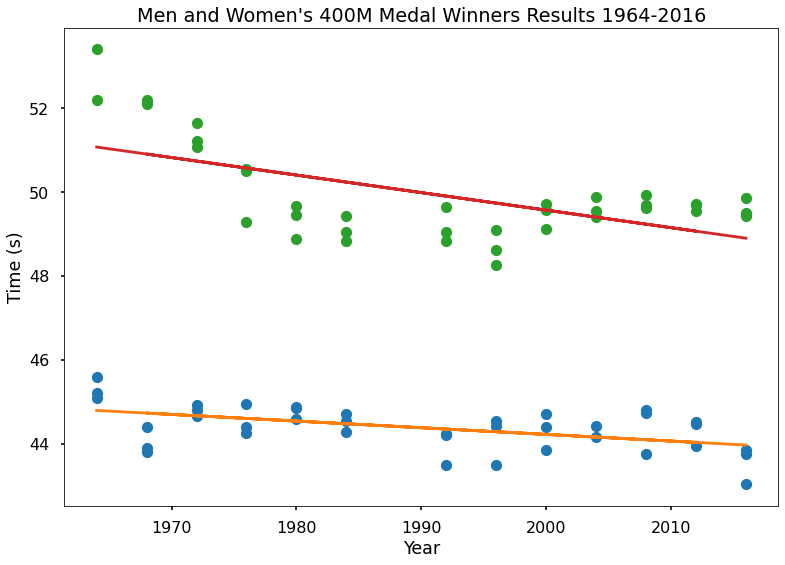

The equation of the men's line is y = 75.9725120886897 + -0.016β
The men's R2 value is -0.26279275356000853
The equation of the women's line is y = 133.1584418604652 + -0.042β
The women's R2 value is -0.3590062563029306


In [15]:
four = tf.loc[tf['Event'] == '400M']
four = four.loc[tf['Year'] >= 1964] #Only have women's data from '64 on
four_m = four.loc[tf['Gender'] == 'M']
four_w = four.loc[tf['Gender'] == 'W']
x_m = four_m['Year'].values
y_m = four_m['Seconds'].values
x_w = four_w['Year'].values
y_w = four_w['Seconds'].values

plt.plot(x_m, y_m, 'o')
m, b = np.polyfit(x_m, y_m, 1)
plt.plot(x_m, m*x_m + b)
plt.plot(x_w, y_w, 'o')
m, b = np.polyfit(x_w, y_w, 1)
plt.plot(x_w, m*x_w + b)
plt.xlabel('Year')
plt.ylabel("Time (s)")
plt.title("Men and Women's 400M Medal Winners Results 1964-2016")
plt.show()

N_m = len(x_m)
x_mean_m = x_m.mean()
y_mean_m = y_m.mean()    
def linear_regression(x_m, y_m):     
    N_m = len(x_m)
    x_mean_m = x_m.mean()
    y_mean_m = y_m.mean()
    
    B1_num = ((x_m - x_mean_m) * (y_m - y_mean_m)).sum()
    B1_den = ((x_m - x_mean_m)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean_m - (B1*x_mean_m)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (reg_line)
print("The equation of the men's line is", linear_regression(x_m, y_m))
N_m = len(x_m)   
num = (N_m * (x_m*y_m).sum()) - (x_m.sum() * y_m.sum())
den = np.sqrt((N_m * (x_m**2).sum() - x_m.sum()**2) * (N_m * (y_m**2).sum() - y_m.sum()**2))
R2 = -(num / den) * (num/den)
print("The men's R2 value is", R2)

N_w = len(x_w)
x_mean_w = x_w.mean()
y_mean_w = y_w.mean()    
def linear_regression(x_w, y_w):     
    N_w = len(x_w)
    x_mean_w = x_w.mean()
    y_mean_w = y_w.mean()
    
    B1_num = ((x_w - x_mean_w) * (y_w - y_mean_w)).sum()
    B1_den = ((x_w - x_mean_w)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean_w - (B1*x_mean_w)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (reg_line)
print("The equation of the women's line is", linear_regression(x_w, y_w))
N_w = len(x_w)   
num = (N_w * (x_w*y_w).sum()) - (x_w.sum() * y_w.sum())
den = np.sqrt((N_w * (x_w**2).sum() - x_w.sum()**2) * (N_w * (y_w**2).sum() - y_w.sum()**2))
R2 = -(num / den) * (num/den)
print("The women's R2 value is", R2)

In [16]:
d4_m = {'Gender':['M', 'M', 'M'], 'Event': ['400M', '400M', '400M'], 'Location': ['Tokyo', 'Tokyo', 'Tokyo'], 
     'Year': ['2020', '2020', '2020'], 'Medal':['G', 'S', 'B'], 'Name':['Steven Gardiner', 'Anthony Zambrano', 'Kirani James'], 
     'Nationality':['BHS', 'COL', 'GRD'], 'Result':['43.85', '44.08', '44.19']}
d4_w = {'Gender':['W', 'W', 'W'], 'Event': ['400M', '400M', '400M'], 'Location': ['Tokyo', 'Tokyo', 'Tokyo'], 
     'Year': ['2020', '2020', '2020'], 'Medal':['G', 'S', 'B'], 'Name':['Shaunae Miller-Uibo', 'Marileidy Paulino', 'Allyson Felix'], 
     'Nationality':['BHS', 'DOM', 'USA'], 'Result':['48.36', '49.20', '49.46']}
df_4m = pd.DataFrame(data=d4_m)
df_4m['Year'] = df_4m.Year.apply(lambda x: int(x))
df_4m['Result'] = df_4m.Result.apply(lambda x: float(x))
fourm_prediction = (75.9725120886897) + (-0.016*2020)
print("Using a linear regression, the average prediction of the men's 2020 medal times was", fourm_prediction, "seconds")
avg_fourm = sum(df_4m['Result'].values) / 3 
print("The average of the men's actual times were", avg_fourm, "seconds")
fourm_error =  (avg_fourm - fourm_prediction) / avg_fourm * 100
print("The men's error was", fourm_error,"%")

df_4w = pd.DataFrame(data=d4_w)
df_4w['Year'] = df_4w.Year.apply(lambda x: int(x))
df_4w['Result'] = df_4w.Result.apply(lambda x: float(x))
fourw_prediction = (133.1584418604652) + (-.042*2020)
print("Using a linear regression, the average prediction of the women's 2020 medal times was", fourw_prediction, "seconds")
avg_fourw = sum(df_4w['Result'].values) / 3 
print("The average of the women's actual times were", avg_fourw, "seconds")
fourw_error =  (avg_fourw - fourw_prediction) / avg_fourw * 100
print("The women's error was", fourw_error,"%")

Using a linear regression, the average prediction of the men's 2020 medal times was 43.6525120886897 seconds
The average of the men's actual times were 44.04 seconds
The men's error was 0.8798544761814306 %
Using a linear regression, the average prediction of the women's 2020 medal times was 48.318441860465185 seconds
The average of the women's actual times were 49.00666666666667 seconds
The women's error was 1.4043493528801845 %


## 800M Analysis

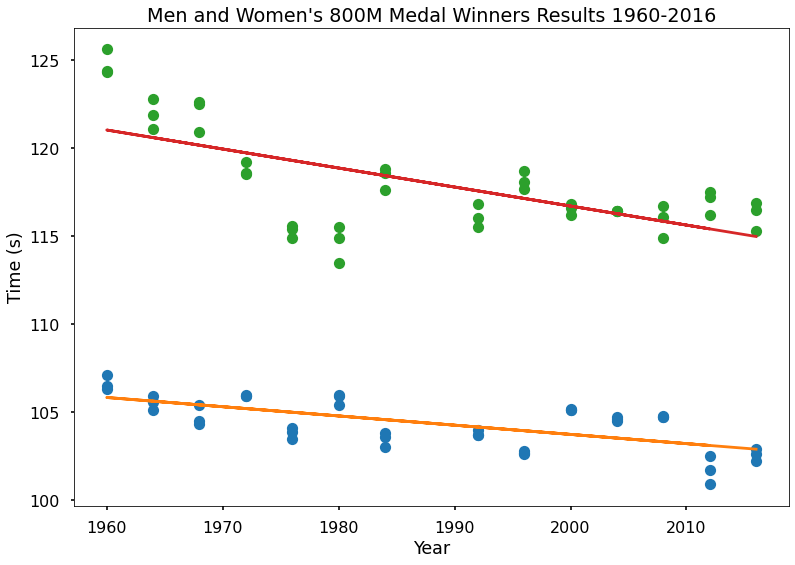

The equation of the men's line is y = 208.5591666666666 + -0.052β
The men's R2 value is -0.4455838486808037
The equation of the women's line is y = 332.7182142857142 + -0.108β
The women's R2 value is -0.44297331660561656


In [17]:
eight = tf.loc[tf['Event'] == '800M']
eight = eight.loc[tf['Year'] >= 1960] #Only have women's data from '60 on
eight_m = eight.loc[tf['Gender'] == 'M']
eight_w = eight.loc[tf['Gender'] == 'W']
x_m = eight_m['Year'].values
y_m = eight_m['Seconds'].values
x_w = eight_w['Year'].values
y_w = eight_w['Seconds'].values

plt.plot(x_m, y_m, 'o')
m, b = np.polyfit(x_m, y_m, 1)
plt.plot(x_m, m*x_m + b)
plt.plot(x_w, y_w, 'o')
m, b = np.polyfit(x_w, y_w, 1)
plt.plot(x_w, m*x_w + b)
plt.xlabel('Year')
plt.ylabel("Time (s)")
plt.title("Men and Women's 800M Medal Winners Results 1960-2016")
plt.show()

N_m = len(x_m)
x_mean_m = x_m.mean()
y_mean_m = y_m.mean()    
def linear_regression(x_m, y_m):     
    N_m = len(x_m)
    x_mean_m = x_m.mean()
    y_mean_m = y_m.mean()
    
    B1_num = ((x_m - x_mean_m) * (y_m - y_mean_m)).sum()
    B1_den = ((x_m - x_mean_m)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean_m - (B1*x_mean_m)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (reg_line)
print("The equation of the men's line is", linear_regression(x_m, y_m))
N_m = len(x_m)   
num = (N_m * (x_m*y_m).sum()) - (x_m.sum() * y_m.sum())
den = np.sqrt((N_m * (x_m**2).sum() - x_m.sum()**2) * (N_m * (y_m**2).sum() - y_m.sum()**2))
R2 = -(num / den) * (num/den)
print("The men's R2 value is", R2)

N_w = len(x_w)
x_mean_w = x_w.mean()
y_mean_w = y_w.mean()    
def linear_regression(x_w, y_w):     
    N_w = len(x_w)
    x_mean_w = x_w.mean()
    y_mean_w = y_w.mean()
    
    B1_num = ((x_w - x_mean_w) * (y_w - y_mean_w)).sum()
    B1_den = ((x_w - x_mean_w)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean_w - (B1*x_mean_w)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (reg_line)
print("The equation of the women's line is", linear_regression(x_w, y_w))
N_w = len(x_w)   
num = (N_w * (x_w*y_w).sum()) - (x_w.sum() * y_w.sum())
den = np.sqrt((N_w * (x_w**2).sum() - x_w.sum()**2) * (N_w * (y_w**2).sum() - y_w.sum()**2))
R2 = -(num / den) * (num/den)
print("The women's R2 value is", R2)

In [18]:
d8_m = {'Gender':['M', 'M', 'M'], 'Event': ['800M', '800M', '800M'], 'Location': ['Tokyo', 'Tokyo', 'Tokyo'], 
     'Year': ['2020', '2020', '2020'], 'Medal':['G', 'S', 'B'], 'Name':['Emmanuel Korir', 'Ferguson Rotich', 'Patryk Dobek'], 
     'Nationality':['KEN', 'KEN', 'POL'], 'Result':['105.06', '105.23', '105.39']}
d8_w = {'Gender':['W', 'W', 'W'], 'Event': ['800M', '800M', '800M'], 'Location': ['Tokyo', 'Tokyo', 'Tokyo'], 
     'Year': ['2020', '2020', '2020'], 'Medal':['G', 'S', 'B'], 'Name':['Athing Mu', 'Keely Hodgkinson', 'Raevyn Rogers'], 
     'Nationality':['USA', 'GBR', 'USA'], 'Result':['115.21', '115.88', '116.81']}
df_8m = pd.DataFrame(data=d8_m)
df_8m['Year'] = df_8m.Year.apply(lambda x: int(x))
df_8m['Result'] = df_8m.Result.apply(lambda x: float(x))
eightm_prediction = (208.55916666666) + (-0.052*2020)
print("Using a linear regression, the average prediction of the men's 2020 medal times was", eightm_prediction, "seconds")
avg_eightm = sum(df_8m['Result'].values) / 3 
print("The average of the men's actual times were", avg_eightm, "seconds")
eightm_error =  (avg_eightm - eightm_prediction) / avg_eightm * 100
print("The men's error was", eightm_error,"%")

df_8w = pd.DataFrame(data=d8_w)
df_8w['Year'] = df_8w.Year.apply(lambda x: int(x))
df_8w['Result'] = df_8w.Result.apply(lambda x: float(x))
eightw_prediction = (332.7182142857142) + (-.108*2020)
print("Using a linear regression, the average prediction of the women's 2020 medal times was", eightw_prediction, "seconds")
avg_eightw = sum(df_8w['Result'].values) / 3 
print("The average of the women's actual times were", avg_eightw, "seconds")
eightw_error =  (avg_eightw - eightw_prediction) / avg_eightw * 100
print("The women's error was", eightw_error,"%")

Using a linear regression, the average prediction of the men's 2020 medal times was 103.51916666666 seconds
The average of the men's actual times were 105.22666666666667 seconds
The men's error was 1.6226875316839917 %
Using a linear regression, the average prediction of the women's 2020 medal times was 114.55821428571423 seconds
The average of the women's actual times were 115.96666666666665 seconds
The women's error was 1.2145320905022354 %


## 1500M Analysis

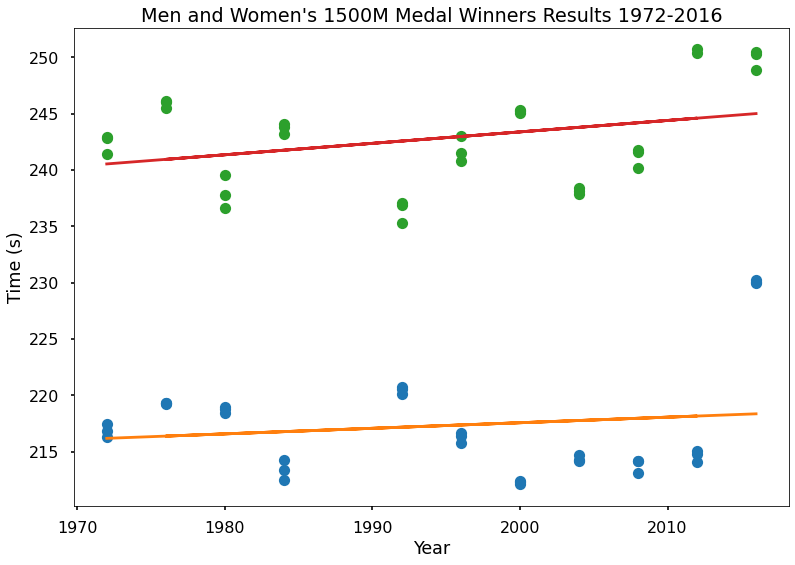

The equation of the men's line is y = 118.66934023285953 + 0.049β
The men's R2 value is -0.021955633431156068
The equation of the women's line is y = 40.2748756218906 + 0.102β
The women's R2 value is -0.11036426856415575


In [19]:
fif = tf.loc[tf['Event'] == '1500M']
fif = fif.loc[tf['Year'] >= 1972] #Only have women's data from '72 on
fif_m = fif.loc[tf['Gender'] == 'M']
fif_w = fif.loc[tf['Gender'] == 'W']
x_m = fif_m['Year'].values
y_m = fif_m['Seconds'].values
x_w = fif_w['Year'].values
y_w = fif_w['Seconds'].values

plt.plot(x_m, y_m, 'o')
m, b = np.polyfit(x_m, y_m, 1)
plt.plot(x_m, m*x_m + b)
plt.plot(x_w, y_w, 'o')
m, b = np.polyfit(x_w, y_w, 1)
plt.plot(x_w, m*x_w + b)
plt.xlabel('Year')
plt.ylabel("Time (s)")
plt.title("Men and Women's 1500M Medal Winners Results 1972-2016")
plt.show()

N_m = len(x_m)
x_mean_m = x_m.mean()
y_mean_m = y_m.mean()    
def linear_regression(x_m, y_m):     
    N_m = len(x_m)
    x_mean_m = x_m.mean()
    y_mean_m = y_m.mean()
    
    B1_num = ((x_m - x_mean_m) * (y_m - y_mean_m)).sum()
    B1_den = ((x_m - x_mean_m)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean_m - (B1*x_mean_m)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (reg_line)
print("The equation of the men's line is", linear_regression(x_m, y_m))
N_m = len(x_m)   
num = (N_m * (x_m*y_m).sum()) - (x_m.sum() * y_m.sum())
den = np.sqrt((N_m * (x_m**2).sum() - x_m.sum()**2) * (N_m * (y_m**2).sum() - y_m.sum()**2))
R2 = -(num / den) * (num/den)
print("The men's R2 value is", R2)

N_w = len(x_w)
x_mean_w = x_w.mean()
y_mean_w = y_w.mean()    
def linear_regression(x_w, y_w):     
    N_w = len(x_w)
    x_mean_w = x_w.mean()
    y_mean_w = y_w.mean()
    
    B1_num = ((x_w - x_mean_w) * (y_w - y_mean_w)).sum()
    B1_den = ((x_w - x_mean_w)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean_w - (B1*x_mean_w)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (reg_line)
print("The equation of the women's line is", linear_regression(x_w, y_w))
N_w = len(x_w)   
num = (N_w * (x_w*y_w).sum()) - (x_w.sum() * y_w.sum())
den = np.sqrt((N_w * (x_w**2).sum() - x_w.sum()**2) * (N_w * (y_w**2).sum() - y_w.sum()**2))
R2 = -(num / den) * (num/den)
print("The women's R2 value is", R2)

In [20]:
d15_m = {'Gender':['M', 'M', 'M'], 'Event': ['1500M', '1500M', '1500M'], 'Location': ['Tokyo', 'Tokyo', 'Tokyo'], 
     'Year': ['2020', '2020', '2020'], 'Medal':['G', 'S', 'B'], 'Name':['Jakob Ingebrigtsen', 'Timothy Cheruiyot', 'Josh Kerr'], 
     'Nationality':['NOR', 'KEN', 'GBR'], 'Result':['208.32', '209.01', '209.05']}
d15_w = {'Gender':['W', 'W', 'W'], 'Event': ['1500M', '1500M', '1500M'], 'Location': ['Tokyo', 'Tokyo', 'Tokyo'], 
     'Year': ['2020', '2020', '2020'], 'Medal':['G', 'S', 'B'], 'Name':['Faith Kipyegon', 'Laura Muir', 'Sifan Hassan'], 
     'Nationality':['KEN', 'GBR', 'NED'], 'Result':['233.11', '234.50', '235.86']}
df_15m = pd.DataFrame(data=d15_m)
df_15m['Year'] = df_15m.Year.apply(lambda x: int(x))
df_15m['Result'] = df_15m.Result.apply(lambda x: float(x))
fifm_prediction = (118.66934023285953) + (0.049*2020)
print("Using a linear regression, the average prediction of the men's 2020 medal times was", fifm_prediction, "seconds")
avg_fifm = sum(df_15m['Result'].values) / 3 
print("The average of the men's actual times were", avg_fifm, "seconds")
fifm_error =  (avg_fifm - fifm_prediction) / avg_fifm * 100
print("The men's error was", fifm_error,"%")

df_15w = pd.DataFrame(data=d15_w)
df_15w['Year'] = df_15w.Year.apply(lambda x: int(x))
df_15w['Result'] = df_15w.Result.apply(lambda x: float(x))
fifw_prediction = (40.2748756218906) + (.102*2020)
print("Using a linear regression, the average prediction of the women's 2020 medal times was", fifw_prediction, "seconds")
avg_fifw = sum(df_15w['Result'].values) / 3 
print("The average of the women's actual times were", avg_fifw, "seconds")
fifw_error =  (avg_fifw - fifw_prediction) / avg_fifw * 100
print("The women's error was", fifw_error,"%")

Using a linear regression, the average prediction of the men's 2020 medal times was 217.64934023285952 seconds
The average of the men's actual times were 208.79333333333332 seconds
The men's error was -4.2415180399403845 %
Using a linear regression, the average prediction of the women's 2020 medal times was 246.3148756218906 seconds
The average of the women's actual times were 234.49 seconds
The women's error was -5.042805928564366 %


## 5000M Analysis

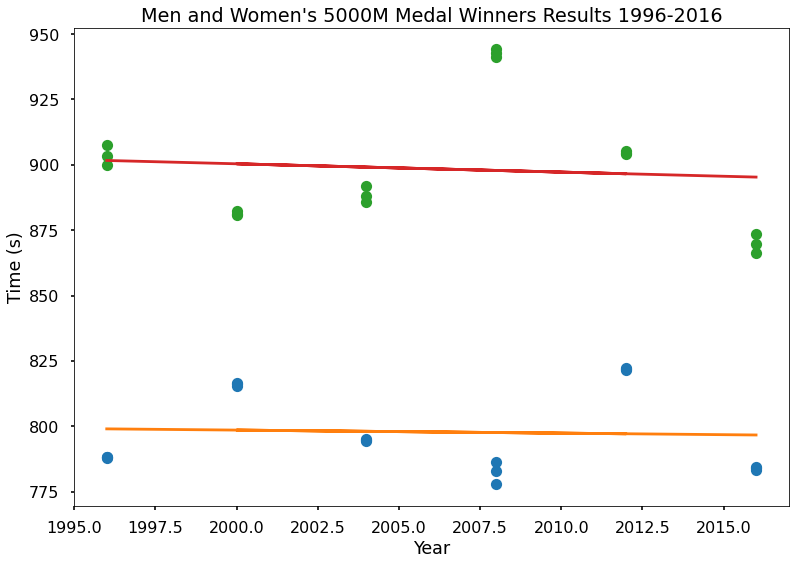

The equation of the men's line is y = 1032.3609523809564 + -0.117β
The men's R2 value is -0.002600575979914708
The equation of the women's line is y = 1535.6215873015856 + -0.318β
The women's R2 value is -0.00865994359804121


In [21]:
fivek = tf.loc[tf['Event'] == '5000M']
fivek = fivek.loc[tf['Year'] >= 1996] #Only have women's data from '92 on
fivek_m = fivek.loc[tf['Gender'] == 'M']
fivek_w = fivek.loc[tf['Gender'] == 'W']
x_m = fivek_m['Year'].values
y_m = fivek_m['Seconds'].values
x_w = fivek_w['Year'].values
y_w = fivek_w['Seconds'].values

plt.plot(x_m, y_m, 'o')
m, b = np.polyfit(x_m, y_m, 1)
plt.plot(x_m, m*x_m + b)
plt.plot(x_w, y_w, 'o')
m, b = np.polyfit(x_w, y_w, 1)
plt.plot(x_w, m*x_w + b)
plt.xlabel('Year')
plt.ylabel("Time (s)")
plt.title("Men and Women's 5000M Medal Winners Results 1996-2016")
plt.show()

N_m = len(x_m)
x_mean_m = x_m.mean()
y_mean_m = y_m.mean()    
def linear_regression(x_m, y_m):     
    N_m = len(x_m)
    x_mean_m = x_m.mean()
    y_mean_m = y_m.mean()
    
    B1_num = ((x_m - x_mean_m) * (y_m - y_mean_m)).sum()
    B1_den = ((x_m - x_mean_m)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean_m - (B1*x_mean_m)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (reg_line)
print("The equation of the men's line is", linear_regression(x_m, y_m))
N_m = len(x_m)   
num = (N_m * (x_m*y_m).sum()) - (x_m.sum() * y_m.sum())
den = np.sqrt((N_m * (x_m**2).sum() - x_m.sum()**2) * (N_m * (y_m**2).sum() - y_m.sum()**2))
R2 = -(num / den) * (num/den)
print("The men's R2 value is", R2)

N_w = len(x_w)
x_mean_w = x_w.mean()
y_mean_w = y_w.mean()    
def linear_regression(x_w, y_w):     
    N_w = len(x_w)
    x_mean_w = x_w.mean()
    y_mean_w = y_w.mean()
    
    B1_num = ((x_w - x_mean_w) * (y_w - y_mean_w)).sum()
    B1_den = ((x_w - x_mean_w)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean_w - (B1*x_mean_w)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (reg_line)
print("The equation of the women's line is", linear_regression(x_w, y_w))
N_w = len(x_w)   
num = (N_w * (x_w*y_w).sum()) - (x_w.sum() * y_w.sum())
den = np.sqrt((N_w * (x_w**2).sum() - x_w.sum()**2) * (N_w * (y_w**2).sum() - y_w.sum()**2))
R2 = -(num / den) * (num/den)
print("The women's R2 value is", R2)

In [22]:
d5_m = {'Gender':['M', 'M', 'M'], 'Event': ['5000M', '5000M', '5000M'], 'Location': ['Tokyo', 'Tokyo', 'Tokyo'], 
     'Year': ['2020', '2020', '2020'], 'Medal':['G', 'S', 'B'], 'Name':['Joshua Cheptegei', 'Mohammed Ahmed', 'Paul Chelimo'], 
     'Nationality':['UGA', 'CAN', 'USA'], 'Result':['778.15', '778.61', '779.05']}
d5_w = {'Gender':['W', 'W', 'W'], 'Event': ['5000M', '5000M', '5000M'], 'Location': ['Tokyo', 'Tokyo', 'Tokyo'], 
     'Year': ['2020', '2020', '2020'], 'Medal':['G', 'S', 'B'], 'Name':['Sifan Hassan', 'Hellen Obiri', 'Gudaf Tsegay'], 
     'Nationality':['NED', 'KEN', 'ETH'], 'Result':['876.79', '878.36', '878.87']}
df_5m = pd.DataFrame(data=d5_m)
df_5m['Year'] = df_5m.Year.apply(lambda x: int(x))
df_5m['Result'] = df_5m.Result.apply(lambda x: float(x))
fivem_prediction = (1032.3609523809564) + (-0.117*2020)
print("Using a linear regression, the average prediction of the men's 2020 medal times was", fivem_prediction, "seconds")
avg_fivem = sum(df_5m['Result'].values) / 3 
print("The average of the men's actual times were", avg_fivem, "seconds")
fivem_error =  (avg_fivem - fivem_prediction) / avg_fivem * 100
print("The men's error was", fivem_error,"%")

df_5w = pd.DataFrame(data=d5_w)
df_5w['Year'] = df_5w.Year.apply(lambda x: int(x))
df_5w['Result'] = df_5w.Result.apply(lambda x: float(x))
fivew_prediction = (1535.6215873015856) + (-.318*2020)
print("Using a linear regression, the average prediction of the women's 2020 medal times was", fivew_prediction, "seconds")
avg_fivew = sum(df_5w['Result'].values) / 3 
print("The average of the women's actual times were", avg_fivew, "seconds")
fivew_error =  (avg_fivew - fivew_prediction) / avg_fivew * 100
print("The women's error was", fivew_error,"%")

Using a linear regression, the average prediction of the men's 2020 medal times was 796.0209523809564 seconds
The average of the men's actual times were 778.6033333333334 seconds
The men's error was -2.2370337117688965 %
Using a linear regression, the average prediction of the women's 2020 medal times was 893.2615873015856 seconds
The average of the women's actual times were 878.0066666666667 seconds
The women's error was -1.7374492944152553 %


## 10000M Analysis

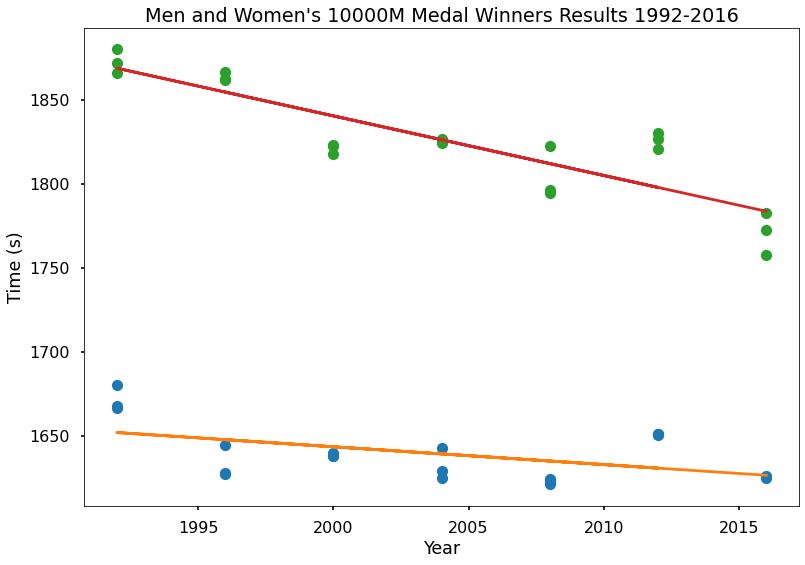

The equation of the men's line is y = 3762.008333333334 + -1.059β
The men's R2 value is -0.26795494381319795
The equation of the women's line is y = 8932.059523809521 + -3.546β
The women's R2 value is -0.7570650388387361


In [23]:
tenk = tf.loc[tf['Event'] == '10000M']
tenk = tenk.loc[tf['Year'] >= 1992] #Only have women's data from '92 on
tenk_m = tenk.loc[tf['Gender'] == 'M']
tenk_w = tenk.loc[tf['Gender'] == 'W']
x_m = tenk_m['Year'].values
y_m = tenk_m['Seconds'].values
x_w = tenk_w['Year'].values
y_w = tenk_w['Seconds'].values

plt.plot(x_m, y_m, 'o')
m, b = np.polyfit(x_m, y_m, 1)
plt.plot(x_m, m*x_m + b)
plt.plot(x_w, y_w, 'o')
m, b = np.polyfit(x_w, y_w, 1)
plt.plot(x_w, m*x_w + b)
plt.xlabel('Year')
plt.ylabel("Time (s)")
plt.title("Men and Women's 10000M Medal Winners Results 1992-2016")
plt.show()

N_m = len(x_m)
x_mean_m = x_m.mean()
y_mean_m = y_m.mean()    
def linear_regression(x_m, y_m):     
    N_m = len(x_m)
    x_mean_m = x_m.mean()
    y_mean_m = y_m.mean()
    
    B1_num = ((x_m - x_mean_m) * (y_m - y_mean_m)).sum()
    B1_den = ((x_m - x_mean_m)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean_m - (B1*x_mean_m)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (reg_line)
print("The equation of the men's line is", linear_regression(x_m, y_m))
N_m = len(x_m)   
num = (N_m * (x_m*y_m).sum()) - (x_m.sum() * y_m.sum())
den = np.sqrt((N_m * (x_m**2).sum() - x_m.sum()**2) * (N_m * (y_m**2).sum() - y_m.sum()**2))
R2 = -(num / den) * (num/den)
print("The men's R2 value is", R2)

N_w = len(x_w)
x_mean_w = x_w.mean()
y_mean_w = y_w.mean()    
def linear_regression(x_w, y_w):     
    N_w = len(x_w)
    x_mean_w = x_w.mean()
    y_mean_w = y_w.mean()
    
    B1_num = ((x_w - x_mean_w) * (y_w - y_mean_w)).sum()
    B1_den = ((x_w - x_mean_w)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean_w - (B1*x_mean_w)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (reg_line)
print("The equation of the women's line is", linear_regression(x_w, y_w))
N_w = len(x_w)   
num = (N_w * (x_w*y_w).sum()) - (x_w.sum() * y_w.sum())
den = np.sqrt((N_w * (x_w**2).sum() - x_w.sum()**2) * (N_w * (y_w**2).sum() - y_w.sum()**2))
R2 = -(num / den) * (num/den)
print("The women's R2 value is", R2)

In [24]:
d10_m = {'Gender':['M', 'M', 'M'], 'Event': ['10000M', '10000M', '10000M'], 'Location': ['Tokyo', 'Tokyo', 'Tokyo'], 
     'Year': ['2020', '2020', '2020'], 'Medal':['G', 'S', 'B'], 'Name':['Selemon Barega', 'Joshua Cheptegei', 'Jacob Kiplimo'], 
     'Nationality':['ETH', 'UGA', 'UGA'], 'Result':['1663.22', '1663.63', '1663.88']}
d10_w = {'Gender':['W', 'W', 'W'], 'Event': ['10000M', '10000M', '10000M'], 'Location': ['Tokyo', 'Tokyo', 'Tokyo'], 
     'Year': ['2020', '2020', '2020'], 'Medal':['G', 'S', 'B'], 'Name':['Sifan Hassan', 'Kalkidan Gezahegne', 'Letesenbet Gidey'], 
     'Nationality':['NED', 'BHR', 'ETH'], 'Result':['1795.32', '1796.18', '1801.72']}
df_10m = pd.DataFrame(data=d10_m)
df_10m['Year'] = df_10m.Year.apply(lambda x: int(x))
df_10m['Result'] = df_10m.Result.apply(lambda x: float(x))
tenm_prediction = (3762.0083333334) + (-1.059*2020)
print("Using a linear regression, the average prediction of the men's 2020 medal times was", tenm_prediction, "seconds")
avg_tenm = sum(df_10m['Result'].values) / 3 
print("The average of the men's actual times were", avg_tenm, "seconds")
tenm_error =  (avg_tenm - tenm_prediction) / avg_tenm * 100
print("The men's error was", tenm_error,"%")

df_10w = pd.DataFrame(data=d10_w)
df_10w['Year'] = df_10w.Year.apply(lambda x: int(x))
df_10w['Result'] = df_10w.Result.apply(lambda x: float(x))
tenw_prediction = (8932.059523809521) + (-3.546*2020)
print("Using a linear regression, the average prediction of the women's 2020 medal times was", tenw_prediction, "seconds")
avg_tenw = sum(df_10w['Result'].values) / 3 
print("The average of the women's actual times were", avg_tenw, "seconds")
tenw_error =  (avg_tenw - tenw_prediction) / avg_tenw * 100
print("The women's error was", tenw_error,"%")

Using a linear regression, the average prediction of the men's 2020 medal times was 1622.8283333334002 seconds
The average of the men's actual times were 1663.5766666666668 seconds
The men's error was 2.4494412640996366 %
Using a linear regression, the average prediction of the women's 2020 medal times was 1769.139523809521 seconds
The average of the women's actual times were 1797.74 seconds
The women's error was 1.5909128233492584 %


## Prediction/Error Summary

Now that I calculated the predictions and errors for each of the events, I wanted to summarize it concisely.
To do so I made a new dataframe and a bar plot.

In [25]:
errors = {"W 100": one_error_w, "M 100": onem_error,"W 200": twow_error, "M 200": twom_error, "W 400":fourw_error, 
          "M 400": fourm_error,"W 800": eightw_error, "M 800": eightm_error,"W 1500": fifw_error, "M 1500": fifm_error,
          "W 5K":fivew_error, "M 5K":fivem_error, "W 10K":tenw_error, "M 10K":tenm_error}
predictions = {"W 100": one_prediction_w, "M 100": onem_prediction, "W 200": twow_prediction, "M 200": twom_prediction, 
               "W 400": fourw_prediction, "M 400": fourm_prediction, "W 800": eightw_prediction, "M 800":eightm_prediction, 
               "W 1500": fifw_prediction, "M 1500": fifm_prediction, "W 5K": fivew_prediction, 
               "M 5K": fivem_prediction, "W 10K": tenw_prediction, "M 10K": tenm_prediction}
actual = {"W 100": one_avg_w, "M 100": onem_avg, "W 200": twow_avg, "M 200": twom_avg, 
               "W 400": avg_fourw, "M 400": avg_fourm, "W 800": avg_eightw, "M 800":avg_eightm, 
               "W 1500": avg_fifw, "M 1500": avg_fifm, "W 5K": avg_fivew, 
               "M 5K": avg_fivem, "W 10K": avg_tenw, "M 10K": avg_tenm}
R2 = {"W 100": -0.789338838685434, "M 100": -0.7716355654924806,"W 200": -0.6775034465421597, "M 200": -0.6901748970007375, 
      "W 400":-0.3590062563029306, "M 400": -0.26279275356000853,"W 800": -0.44297331660561656, "M 800": -0.4455838486808037,
      "W 1500": -0.11036426856415575, "M 1500": -0.021955633431156068,
          "W 5K":-0.00865994359804121, "M 5K":-0.002600575979914708, "W 10K":-0.7570650388387361, "M 10K":-0.26795494381319795}

In [26]:
sumdf1 = pd.DataFrame(errors.items())
sumdf1.columns = ['Event', 'Error (%)']
sumdf2 = pd.DataFrame(predictions.items())
sumdf2.columns = ['Event', '2020 Prediction (s)']
sumdf3 = pd.DataFrame(actual.items())
sumdf3.columns = ['Event', '2020 Actual (s)']
sumdf4 = pd.DataFrame(R2.items())
together = [sumdf1, sumdf2, sumdf3, sumdf4]
result = pd.concat(together)
two = sumdf1.merge(sumdf2)
final = two.merge(sumdf3)
final['2020 Difference (s)'] = abs(final['2020 Prediction (s)'] - final['2020 Actual (s)'])

In [27]:
final

,Event,Error (%),2020 Prediction (s),2020 Actual (s),2020 Difference (s)
0,W 100,-6.213926,11.368431,10.703333,0.665097
1,M 100,-7.640669,10.595430,9.843333,0.752097
2,W 200,1.073471,21.503330,21.736667,0.233337
3,M 200,-2.654597,20.202425,19.680000,0.522425
4,W 400,1.404349,48.318442,49.006667,0.688225
5,M 400,0.879854,43.652512,44.040000,0.387488
6,W 800,1.214532,114.558214,115.966667,1.408452
7,M 800,1.622688,103.519167,105.226667,1.707500
8,W 1500,-5.042806,246.314876,234.490000,11.824876
9,M 1500,-4.241518,217.649340,208.793333,8.856007


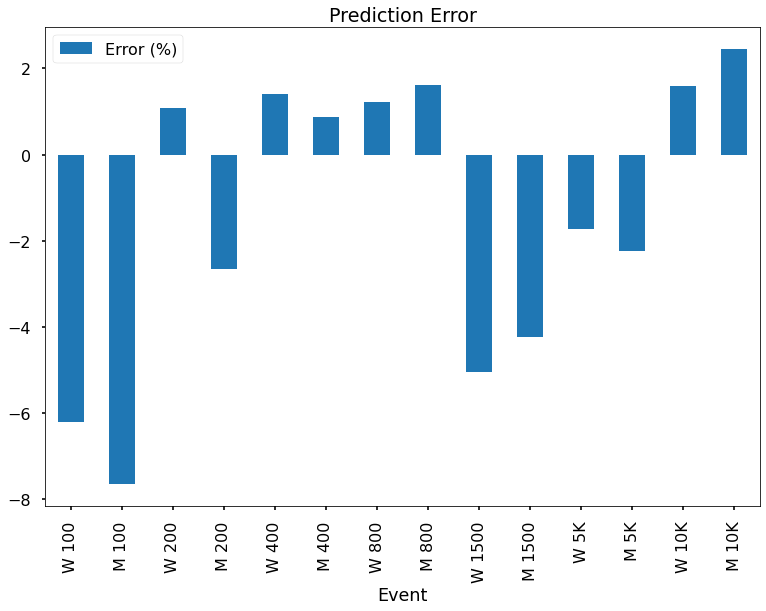

In [28]:
bp = final.plot.bar(x = "Event", y = "Error (%)")
bp = bp.set_title('Prediction Error')

# A positive error menas the prediction was faster than actual and vice versa

Our two biggest event errors came in the 100M and the 1500M and both predicted slower times. For the 100M, we have the most data with that going back to 1928 where times were much slower. If we started and onyl went back 50 years, I believe it would be more accurate. For the 1500, it has become a very tactical race at the Olympics so some years can be very slow while others very fast. Also in 2020, both Olympic records were set in very fast races.
Below I ran a t-test and determined there wasn't a significant difference between sprints and distance (I included the 800 in both to have equal numbers of events, plus its an in between event)

In [29]:
sprints = [one_error_w, onem_error, twow_error, twom_error, fourw_error, fourm_error, eightw_error, eightm_error]
distance = [fifw_error, fifm_error, fivew_error, fivem_error, tenw_error, tenm_error, eightw_error, eightm_error]
event_t_test = ttest_rel(sprints, distance)
event_t_test

Ttest_relResult(statistic=-0.7922251550306486, pvalue=0.45423525591483993)

## Paris 2024

With Tokyo 2020, I was able to compare predictions to actual results. I want to solely using this data, predict what the average medal times for the next Olympics are going to be. In a couple years, I'll have to check back and see how close (or far) I was.

In [30]:
one_2024_m = (28.77542985758498) + (-0.009*2024)
one_2024_w = (39.648430585487034) + (-0.014*2024)
two_2024_m = (54.54242467951077) + (-0.017*2024)
two_2024_w = (94.22332984567093) + (-0.036*2024)
four_2024_m = (75.9725120886897) + (-0.016*2024)
four_2024_w = (133.1584418604652) + (-.042*2024)
eight_2024_m = (208.55916666666) + (-0.052*2024)
eight_2024_w = (332.7182142857142) + (-.108*2024)
fif_2024_m = (118.66934023285953) + (0.049*2024)
fif_2024_w = (40.2748756218906) + (.102*2024)
five_2024_m = (1032.3609523809564) + (-0.117*2024)
five_2024_w = (1535.6215873015856) + (-.318*2024)
ten_2024_m = (3762.0083333334) + (-1.059*2024)
ten_2024_w = (8932.059523809521) + (-3.546*2024)

predictions_2024 = {"W 100": one_2024_w, "M 100": one_2024_m, "W 200": two_2024_w, "M 200": two_2024_m, 
               "W 400": four_2024_w, "M 400": four_2024_m, "W 800": eight_2024_w, "M 800":eight_2024_m, 
               "W 1500": fif_2024_w, "M 1500": fif_2024_m, "W 5K": five_2024_w, 
               "M 5K": five_2024_m, "W 10K": ten_2024_w, "M 10K": ten_2024_m}

sumdf5 = pd.DataFrame(predictions_2024.items())
sumdf5.columns = ['Event', '2024 Prediction (s)']

paris = final.merge(sumdf5)
paris['2024 - 2020 Difference (s)'] = abs(paris['2024 Prediction (s)'] - paris['2020 Prediction (s)'])

In [31]:
paris 

,Event,Error (%),2020 Prediction (s),2020 Actual (s),2020 Difference (s),2024 Prediction (s),2024 - 2020 Difference (s)
0,W 100,-6.213926,11.368431,10.703333,0.665097,11.312431,0.056
1,M 100,-7.640669,10.595430,9.843333,0.752097,10.559430,0.036
2,W 200,1.073471,21.503330,21.736667,0.233337,21.359330,0.144
3,M 200,-2.654597,20.202425,19.680000,0.522425,20.134425,0.068
4,W 400,1.404349,48.318442,49.006667,0.688225,48.150442,0.168
5,M 400,0.879854,43.652512,44.040000,0.387488,43.588512,0.064
6,W 800,1.214532,114.558214,115.966667,1.408452,114.126214,0.432
7,M 800,1.622688,103.519167,105.226667,1.707500,103.311167,0.208
8,W 1500,-5.042806,246.314876,234.490000,11.824876,246.722876,0.408
9,M 1500,-4.241518,217.649340,208.793333,8.856007,217.845340,0.196


## Improvements

Once again, although the year ranges vary, I was curious to see the improvment percentage between each event and if its even or if one gender has improved more than the other. Before analyzing it, my guess is that women have improved more since they are "newer" at the sport.

In [32]:
one_dm = one_m['Seconds'].max() - one_m['Seconds'].min()
one_dw = one_w['Seconds'].max() - one_w['Seconds'].min()
two_dm = two_m['Seconds'].max() - two_m['Seconds'].min()
two_dw = two_w['Seconds'].max() - two_w['Seconds'].min()
four_dm = four_m['Seconds'].max() - four_m['Seconds'].min()
four_dw = four_w['Seconds'].max() - four_w['Seconds'].min()
eight_dm = eight_m['Seconds'].max() - eight_m['Seconds'].min()
eight_dw = eight_w['Seconds'].max() - eight_w['Seconds'].min()
fif_dm = fif_m['Seconds'].max() - fif_m['Seconds'].min()
fif_dw = fif_w['Seconds'].max() - fif_w['Seconds'].min()
five_dm = fivek_m['Seconds'].max() - fivek_m['Seconds'].min()
five_dw = fivek_w['Seconds'].max() - fivek_w['Seconds'].min()
ten_dm = tenk_m['Seconds'].max() - tenk_m['Seconds'].min()
ten_dw = tenk_w['Seconds'].max() - tenk_w['Seconds'].min()

one_pm = abs(one_m['Seconds'].min() - one_m['Seconds'].max())/(one_m['Seconds'].max()) * 100
one_pw = abs(one_w['Seconds'].min() - one_w['Seconds'].max())/(one_w['Seconds'].max()) * 100
two_pm = abs(two_m['Seconds'].min() - two_m['Seconds'].max())/(two_m['Seconds'].max()) * 100
two_pw = abs(two_w['Seconds'].min() - two_w['Seconds'].max())/(two_w['Seconds'].max()) * 100
four_pm = abs(four_m['Seconds'].min() - four_m['Seconds'].max())/(four_m['Seconds'].max()) * 100
four_pw = abs(four_w['Seconds'].min() - four_w['Seconds'].max())/(four_w['Seconds'].max()) * 100
eight_pm = abs(eight_m['Seconds'].min() - eight_m['Seconds'].max())/(eight_m['Seconds'].max()) * 100
eight_pw = abs(eight_w['Seconds'].min() - eight_w['Seconds'].max())/(eight_w['Seconds'].max()) * 100
fif_pm = abs(fif_m['Seconds'].min() - fif_m['Seconds'].max())/(fif_m['Seconds'].max()) * 100
fif_pw = abs(fif_w['Seconds'].min() - fif_w['Seconds'].max())/(fif_w['Seconds'].max()) * 100
five_pm = abs(fivek_m['Seconds'].min() - fivek_m['Seconds'].max())/(fivek_m['Seconds'].max()) * 100
five_pw = abs(fivek_w['Seconds'].min() - fivek_w['Seconds'].max())/(fivek_w['Seconds'].max()) * 100
ten_pm = abs(tenk_m['Seconds'].min() - tenk_m['Seconds'].max())/(tenk_m['Seconds'].max()) * 100
ten_pw = abs(tenk_w['Seconds'].min() - tenk_w['Seconds'].max())/(tenk_w['Seconds'].max()) * 100


improvements = {"W 100": one_dw, "M 100": one_dm,"W 200": two_dw, "M 200": two_dm, "W 400":four_dw, 
          "M 400": four_dm,"W 800": eight_dw, "M 800": eight_dm,"W 1500": fif_dw, "M 1500": fif_dm,
          "W 5K":five_dw, "M 5K":five_dm, "W 10K":ten_dw, "M 10K":ten_dm}
percents = {"W 100": one_pw, "M 100": one_pm,"W 200": two_pw, "M 200": two_pm, "W 400":four_pw, 
          "M 400": four_pm,"W 800": eight_pw, "M 800": eight_pm,"W 1500": fif_pw, "M 1500": fif_pm,
          "W 5K":five_pw, "M 5K":five_pm, "W 10K":ten_pw, "M 10K":ten_pm}

improv = pd.DataFrame(improvements.items())
improv.columns = ['Event', 'Improvements (s)']
per = pd.DataFrame(percents.items())
per.columns = ['Event', 'Percent Improvement']
improv = improv.merge(per)
improv = improv.sort_values(['Percent Improvement'], ascending = False)
improv

,Event,Improvements (s),Percent Improvement
2,W 200,3.46,13.730159
0,W 100,1.49,12.213115
1,M 100,1.27,11.651376
4,W 400,5.15,9.644195
6,W 800,12.10,9.633758
3,M 200,1.90,8.962264
10,W 5K,77.90,8.251245
9,M 1500,18.10,7.862728
12,W 10K,122.50,6.516304
8,W 1500,15.40,6.142800


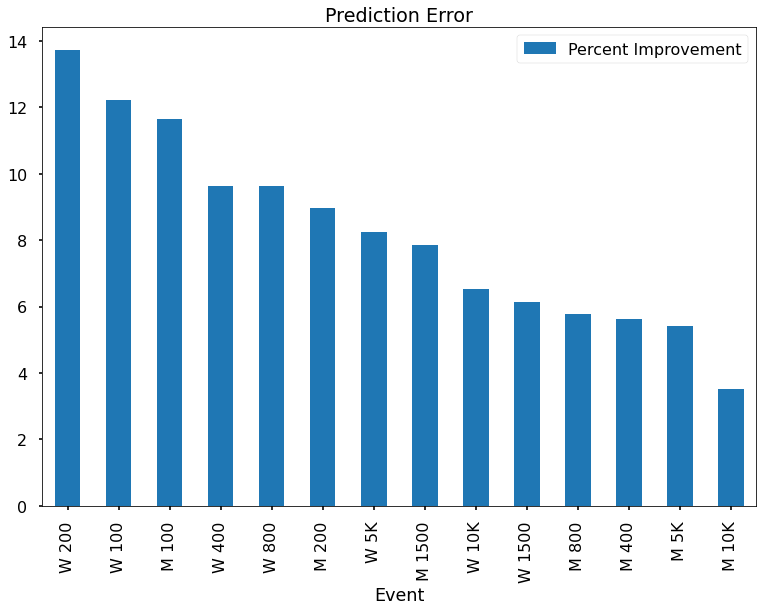

In [33]:
ibp = improv.plot.bar(x = "Event", y = "Percent Improvement")
ibp = ibp.set_title('Prediction Error')

In [34]:
womens = [one_pw, two_pw, four_pw, eight_pw, fif_pw, five_pw, ten_pw]
mens = [one_pm, two_pm, four_pm, eight_pm, fif_pm, five_pm, ten_pm]

avg_wi = mean(womens)
print("The average improvement across all Women's events was {:0.2f}%.".format(avg_wi))
avg_mi = mean(mens)
print("The average improvement across all Men's events was {:0.2f}%.".format(avg_mi))
sd_wi = stdev(womens)
print("The Standard Deviation across all Women's events was {:0.2f}%.".format(sd_wi))
sd_mi = stdev(mens)
print("The Standard Deviation across all Men's events was {:0.2f}%.".format(sd_mi))

improv_t_test = ttest_rel(womens, mens)
improv_t_test

The average improvement across all Women's events was 9.45%.
The average improvement across all Men's events was 6.98%.
The Standard Deviation across all Women's events was 2.80%.
The Standard Deviation across all Men's events was 2.72%.


Ttest_relResult(statistic=2.8697962296549995, pvalue=0.028434670666617232)

### After running the t-test, we see that there is a significant difference in improvement between men and women

## Country Medal Counts

After looking at the data, I was curious to see how the medal count was split up. It is apparent that the US is the heavy track favorite and helps with their overall Summer Olympic success.

In [35]:
tf.head()

,Gender,Event,Location,Year,Medal,Name,Nationality,Result,Distance (m),Seconds
0,M,10000M,Rio,2016,G,Mohamed FARAH,GBR,27:05.0,10000.0,1625.0
1,M,10000M,Rio,2016,S,Paul Kipngetich TANUI,KEN,27:05.6,10000.0,1625.6
2,M,10000M,Rio,2016,B,Tamirat TOLA,ETH,27:06.3,10000.0,1626.3
3,M,10000M,Beijing,2008,G,Kenenisa BEKELE,ETH,27:01.2,10000.0,1621.2
4,M,10000M,Beijing,2008,S,Sileshi SIHINE,ETH,27:02.8,10000.0,1622.8


In [36]:
nat = tf.groupby('Nationality')['Name'].nunique()
nat = nat.sort_values(ascending = False)
nat

Nationality
USA    154
GBR     51
KEN     45
ETH     29
AUS     21
      ... 
GRN      1
LUX      1
MEX      1
MOZ      1
YUG      1
Name: Name, Length: 76, dtype: int64

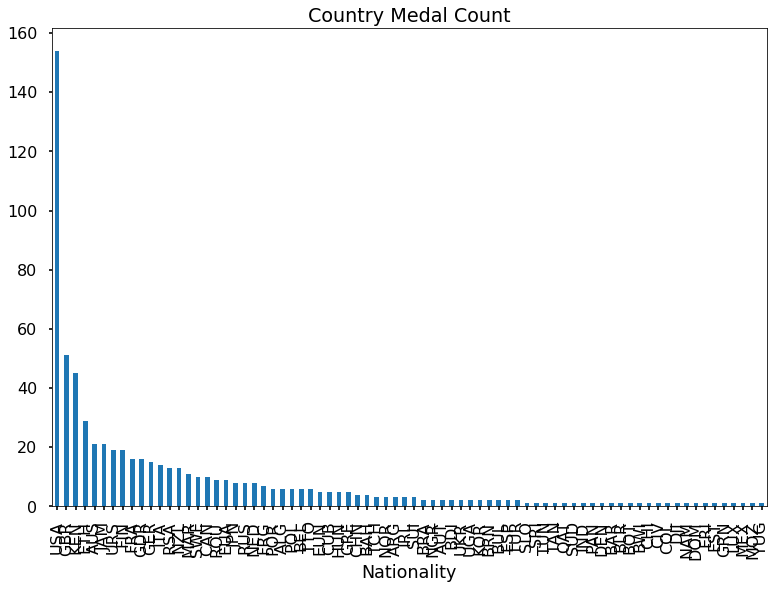

In [37]:
np = nat.plot.bar(x = "Country", y = "Count")
np = np.set_title('Country Medal Count')

# Summary

After working with this dataset, I definitely found what I set out to and discovered some pretty interesting things along the way.
1) Between sprint and distance events, there was no significant difference in their prediction errors to the Tokyo 2020 results.
2) The 1500 and 5000 had some very interesting R2 values and linear regression plots
3) Women have improved much more relative to men
4) The USA has A LOT of track and field medals